In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-4
batch_size = 16
wd = 1e-5
image_size = 512
backbone='tf_efficientdet_lite0'
vertical_type = "axial"
train_portion = 0.5
milestones = [50, 100, 150, 200]
model_name = "effdet"
epochs = 100

In [3]:
wandb_entity='longyi'
model_name = "effdet"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "backbone" : backbone,
    "image_size" : image_size,
})
wandb.run.name = f'axial_detection_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


'axial_detection_effdet_210507'

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold



# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv')).set_index('StudyInstanceUID')
print(len(df))
df.head()

7203


,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
StudyInstanceUID,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [7]:
boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'train_axial_boundary.csv')).set_index('UID')
print(len(boundary_df))
boundary_df.head()

2012


,aspect,xmin,ymin,xmax,ymax
UID,,,,,
1.2.826.0.1.3680043.10001,2.461541,78.849180,47.024193,453.30298,420.97748
1.2.826.0.1.3680043.10005,2.091504,93.988910,63.075333,373.98172,460.40836
1.2.826.0.1.3680043.10014,3.418803,22.234573,11.231842,500.32007,506.54834
1.2.826.0.1.3680043.10016,1.136566,73.564575,27.175400,444.91382,438.84436
1.2.826.0.1.3680043.10032,1.951216,85.200000,30.145882,420.28073,443.24400


In [8]:
bbox_boundary_df = boundary_df.loc[df.index.unique().values]
len(bbox_boundary_df)

234

In [9]:
def square_crop_position(crop_box, image_size=512):
    """
    crop box 를 정방형으로 만들어준다.
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    left, top, right, bottom = crop_box
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom


square_crop_position([0, 1, 2, 4], image_size=5)

(0, 1, 3, 4)

In [10]:
for i in range(len(bbox_boundary_df)):
    boundary = bbox_boundary_df.iloc[i]
    df.loc[boundary.name, ['xmin','ymin','xmax','ymax']] = square_crop_position(boundary[['xmin','ymin','xmax','ymax']].values, image_size)
print(len(df))
df.head()

7203


,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number,xmin,ymin,xmax,ymax
StudyInstanceUID,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133,36.93093,35.741394,430.5001,429.310564
1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134,36.93093,35.741394,430.5001,429.310564
1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135,36.93093,35.741394,430.5001,429.310564
1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136,36.93093,35.741394,430.5001,429.310564
1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137,36.93093,35.741394,430.5001,429.310564


In [11]:
pd.isna(df["axial_index"]).all()

False

In [12]:
def crop_image(img:Image, bbox, crop_box):
    """

    :param img:
    :param bbox: [left, top, right, bottom]
    :param crop_box:[left, top, right, bottom]
    :return:
    """
    left, top, right, bottom = crop_box
    img = img.crop(crop_box)
    bbox[0] -= left
    bbox[1] -= top
    bbox[2] -= left
    bbox[3] -= top

    return img, bbox

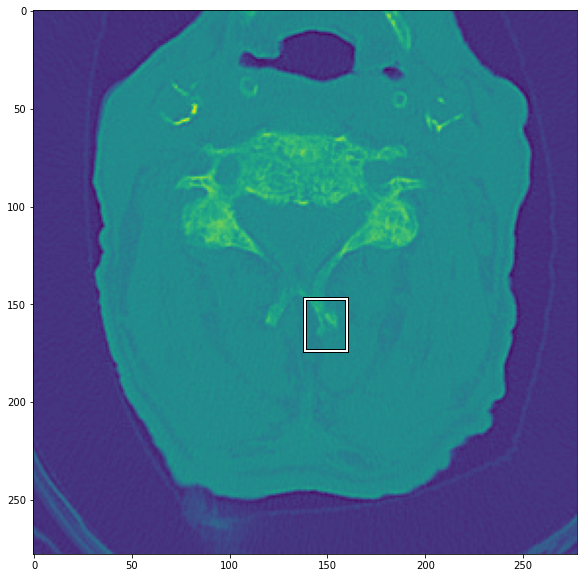

In [13]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = df.iloc[370]
image = Image.open(os.path.join(IMAGES_DIR, s.name, f'{int(s.axial_index)}.jpeg'))
bbox = list(s[['x', 'y','width','height']])
bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
crop_box = s[['xmin','ymin','xmax','ymax']]
image, bbox = crop_image(image, bbox, crop_box)
show_image(image, bbox)

## Dataset

In [14]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, df):
        self.image_dir = images_dir_path
        self.df = df

    def __len__(self) -> int:
        return len(self.df)

    def get_image_and_labels_by_idx(self, idx):
        s = self.df.iloc[idx]
        # img = Image.open(os.path.join(self.images_dir_path, s['StudyInstanceUID'], f"{s['axial_index']}.jpeg"))
        # print(s)
        UID = s.name
        slice = int(s['axial_index'])
        r = Image.open(os.path.join(self.image_dir, UID, f"{slice-1}.jpeg"))
        g = Image.open(os.path.join(self.image_dir, UID, f"{slice-0}.jpeg"))
        b = Image.open(os.path.join(self.image_dir, UID, f"{slice+1}.jpeg"))
        img = Image.merge('RGB', (r, g, b))

        pascal_bboxes = [[s.x, s.y, s.x + s.width, s.y + s.height]]
        class_labels = np.ones(1)

        crop_box = s[['xmin','ymin','xmax','ymax']].values
        return img, pascal_bboxes, class_labels, idx, crop_box

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, df)
len(da)
da.get_image_and_labels_by_idx(0)

(<PIL.Image.Image image mode=RGB size=512x512 at 0x7FAA400F0C40>,
 [[219.27715, 216.71419, 236.58155, 237.09936]],
 array([1.]),
 0,
 array([ 36.93093 ,  35.741394, 430.5001  , 429.310564]))

## Transform

{'bboxes': tensor([[270.9380, 254.9595, 319.6752, 294.8499]]), 'labels': tensor([1.], dtype=torch.float64), 'image_id': tensor([370]), 'img_size': (512, 512), 'img_scale': tensor([1.])}


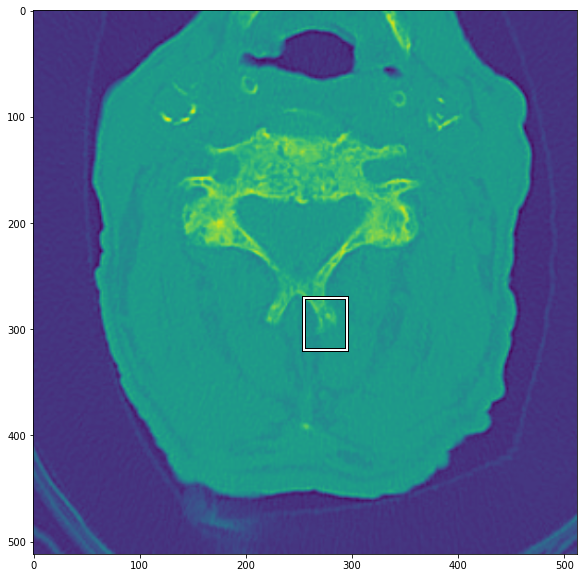

In [15]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            # A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
            crop_box
        ) = self.ds.get_image_and_labels_by_idx(index)

        image, pascal_bboxes = crop_image(image, pascal_bboxes[0], crop_box)
        pascal_bboxes[0] = max(0, pascal_bboxes[0])
        pascal_bboxes[1] = max(0, pascal_bboxes[1])
        pascal_bboxes[2] = min(image.width, pascal_bboxes[2])
        pascal_bboxes[3] = min(image.height, pascal_bboxes[3])

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": [pascal_bboxes],
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                            :, [1, 0, 3, 2]
                                            ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)


train_dataset = EfficientDetDataset(da, transforms=get_train_transforms())
img, ann, idx = train_dataset[370]
print(ann)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[0, :, :])
draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])


In [16]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [17]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

## Model

In [18]:
from effdet import create_model
model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
model = model.to(device)

In [19]:
images, anns, _, image_ids = next(iter(train_loader))
print(anns)
print(images.shape)
# images = images.to(device)
# anns = {
#     'bbox' : [tensor.to(device) for tensor in anns['bbox']],
#     'cls' : [tensor.to(device) for tensor in anns['cls']],
#     'img_size' : anns['img_size'].to(device),
#     'img_scale' : anns['img_scale'].to(device)
# }
# model(images, anns)

{'bbox': [tensor([[  0.0000,  63.7802, 427.7767, 484.2494]]), tensor([[169.1162, 169.9475, 265.5594, 255.0445]]), tensor([[110.6343, 166.3858, 251.7625, 349.6132]]), tensor([[ 61.8744, 116.0996, 250.6671, 332.5173]]), tensor([[147.5919, 361.2054, 245.4348, 475.1322]]), tensor([[157.8146, 167.4676, 355.1578, 354.8644]]), tensor([[118.2465,  92.5185, 238.4766, 203.9743]]), tensor([[233.2359, 218.6455, 315.8771, 274.3923]]), tensor([[ 55.0907, 115.3583, 155.9774, 383.9691]]), tensor([[ 63.4970, 108.4011, 193.7270, 399.1886]]), tensor([[114.1735,  38.2913, 367.1475, 349.3646]]), tensor([[ 70.9346,  91.4941, 209.4924, 328.9389]]), tensor([[212.0304,  77.0704, 322.0814, 372.8892]]), tensor([[ 64.9449, 162.6991, 158.4276, 358.7306]]), tensor([[113.8115,  91.5713, 244.6309, 385.7467]]), tensor([[215.2276, 326.4486, 293.8493, 401.2352]])], 'cls': [tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)


## Train one epoch

In [21]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (images, anns, _, _) in enumerate(train_iter):
        images = images.to(device)
        anns = {
            'bbox' : [tensor.to(device) for tensor in anns['bbox']],
            'cls' : [tensor.to(device) for tensor in anns['cls']],
            'img_size' : anns['img_size'].to(device),
            'img_scale' : anns['img_scale'].to(device)
        }

        with torch.cuda.amp.autocast(device == 'cuda'):
            losses = model(images, anns)
            loss, class_loss, box_loss = losses['loss'], losses['class_loss'], losses['box_loss']

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {class_loss.item():.4f} b {box_loss.item():.4f}")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_class_loss': class_loss.item(),
                'train_box_loss': box_loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

        # if i % 100 == 0:
        #     with torch.no_grad():
        #         inference(model, val_dataset)
        #         # infer_bad_sample(wandb_log=True)
        #     model.train()

    return np.mean(loss_list)

In [22]:
epoch = 0

In [23]:
for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    # with torch.no_grad():
    #     evaluate(epoch, model, val_loader)


    epoch += 1
    scheduler.step()

t 54 loss 0.0358 c 0.0219 b 0.0003:  20%|█▉        | 89/450 [00:20<01:23,  4.33it/s]


KeyboardInterrupt: 

In [24]:
state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "epoch": epoch,
}
torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))